In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from shapely.geometry import Point
import geopandas as gpd
import geojsoncontour
import json
import folium
from matplotlib import ticker, cm
from matplotlib.colors import rgb2hex
import re

In [2]:
def convert_to_utm(x,y):
    '''
    Converts wgs84 coordinate system to utm coordinates
    '''
    point = gpd.GeoSeries([Point(x, y)],crs="epsg:4326").to_crs("epsg:5243").values[0]
    return point.x,point.y

## Calculate the risk

**Geometric likelihood of an accident at a given point:**
<font size="5">
 
$ p(\theta, r) = k . e ^{-\big(\frac{r}{r_0} + \frac{|\theta|}{\theta_0}\big)}$
</font>

In [3]:
# constants of plane depeding on the plane size: large or small
r0 = 5000  ## unit is KM
theta0 = 5 ## unit is degrees
k = 0.23 ## constant
P_airport =(0.02*10**-6)*100 ## likelihood of an accident at frankfurt

In [4]:
# location 1
x1,y1 = 8.534724, 50.032642
x1_utm, y1_utm = convert_to_utm(x1,y1)
x1_utm, y1_utm

(-140684.43056614595, -105634.16767475108)

In [5]:
# location 2
x2,y2 = 8.534249, 50.027578
x2_utm, y2_utm = convert_to_utm(x2,y2)
x2_utm, y2_utm

(-140733.47084670607, -106195.90364623418)

In [6]:
d_i = 10 # distance interval
max_d = 10000 # maximum distance
a_i = 5 # angle interval
max_a = 60 # maximum angle

def risk_contour(x_utm, y_utm, angle=202):
    radius = np.arange(0+d_i,max_d+d_i,d_i)
    angles = np.arange(-max_a,max_a+a_i,a_i)

    R,T = np.meshgrid(radius,angles)
    
    X = x_utm + R*np.cos(np.radians(angle+T))
    Y = y_utm + R*np.sin(np.radians(angle+T))

    ## Calculate geometric 
    Z = P_airport * k * np.exp(-(R/r0+np.abs(T)/theta0))
    return X,Y,Z

In [7]:
X1,Y1,Z1 = risk_contour(x1_utm,y1_utm, angle=202)
X2,Y2,Z2 = risk_contour(x2_utm, y2_utm, angle=202)
X1

array([[-140692.31067368, -140700.19078122, -140708.07088875, ...,
        -148548.77788714, -148556.65799468, -148564.53810221],
       [-140692.81727183, -140701.2039775 , -140709.59068318, ...,
        -149054.36283424, -149062.74953992, -149071.1362456 ],
       [-140693.26004207, -140702.089518  , -140710.91899393, ...,
        -149496.24754288, -149505.07701881, -149513.90649474],
       ...,
       [-140687.52073609, -140690.61090603, -140693.70107598, ...,
        -143768.42017001, -143771.51033995, -143774.6005099 ],
       [-140686.68007669, -140688.92958723, -140691.17909778, ...,
        -142929.4420885 , -142931.69159904, -142933.94110958],
       [-140685.82229716, -140687.21402817, -140688.60575917, ...,
        -142073.37811373, -142074.76984474, -142076.16157575]])

## plot contours

In [8]:
def fmt(x, pos):
    b = '{:.2e}'.format(x).split('e')[1]
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

values = [10**-i for i in range(3,10)][::-1]
colors = ['black', 'darkgreen', 'yellow', 'red', 'purple', 'cyan']
labels = [-1*int("{:.0e}".format(x).split("e-0")[1]) for x in values]

print(colors)
print(values)
print(labels)

['black', 'darkgreen', 'yellow', 'red', 'purple', 'cyan']
[1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001]
[-9, -8, -7, -6, -5, -4, -3]


In [9]:
def get_num(text):
    pattern = r"-\d+"
    return int(re.findall(pattern, str(text))[0])

vmin, vmax = get_num(np.min(Z1)), get_num(np.max(Z1))+1
scale = list(range(vmin, vmax+1))[1:]
len(scale)

7

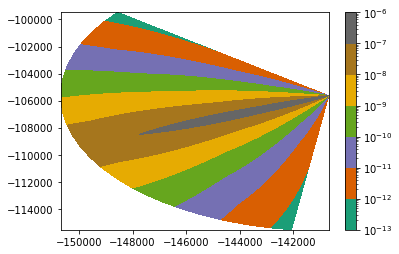

In [10]:
color_dict = {}
colormap = cm.get_cmap('Dark2', len(scale))
contour_utm1 = plt.contourf(X1,Y1,Z1, locator=ticker.LogLocator(),  cmap=colormap)
cb = plt.colorbar()
plt.show()

In [11]:
colormap.colors

array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.45882353, 0.43921569, 0.70196078, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.90196078, 0.67058824, 0.00784314, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ]])

In [12]:
for t,c in zip(cb.ax.get_yticklabels()[1:], colormap.colors):
    color_dict[get_num(t.get_text())] = rgb2hex(c) 
    
color_dict

{-12: '#1b9e77',
 -11: '#d95f02',
 -10: '#7570b3',
 -9: '#66a61e',
 -8: '#e6ab02',
 -7: '#a6761d',
 -6: '#666666'}

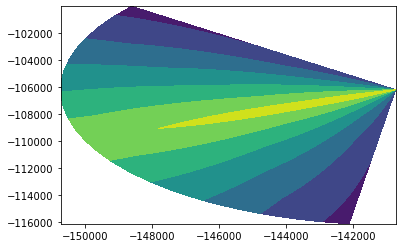

In [13]:
contour_utm2 = plt.contourf(X2,Y2,Z2, locator=ticker.LogLocator())

## Shapely
**Plot in utm coordinates:**

In [14]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contour_utm1)

c1 = json.loads(geojson)

In [15]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contour_utm2)

c2 = json.loads(geojson)

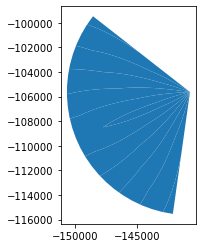

In [16]:
gdf1 = gpd.GeoDataFrame.from_features(c1, crs="epsg:5243")
gdf1["title"] = [get_num(t.get_text()) for t in cb.ax.get_yticklabels()[1:]]
gdf1.drop(["stroke","stroke-opacity","stroke-width"], axis=1, inplace=True)
gdf1.plot()

In [17]:
gdf2 = gpd.GeoDataFrame.from_features(c2, crs="epsg:5243")
gdf2["title"] = [get_num(t.get_text()) for t in cb.ax.get_yticklabels()[1:]]
gdf2.drop(["stroke","stroke-opacity","stroke-width"], axis=1, inplace=True)
gdf2

geometry     fill  fill-opacity  \
0  MULTIPOLYGON (((-144831.127 -102994.464, -1448...  #481b6d           0.9   
1  MULTIPOLYGON (((-140749.231 -106183.590, -1407...  #3f4788           0.9   
2  MULTIPOLYGON (((-140750.402 -106185.279, -1407...  #2e6e8e           0.9   
3  MULTIPOLYGON (((-140752.154 -106188.820, -1407...  #21918c           0.9   
4  MULTIPOLYGON (((-140753.216 -106192.796, -1407...  #2db27d           0.9   
5  MULTIPOLYGON (((-140753.443 -106196.796, -1407...  #73d056           0.9   
6  MULTIPOLYGON (((-140752.878 -106200.664, -1407...  #d0e11c           0.9   

   title  
0    -12  
1    -11  
2    -10  
3     -9  
4     -8  
5     -7  
6     -6

In [18]:
overlapped = gpd.overlay(gdf1,gdf2, how='union')
overlapped['title'] = np.max(overlapped[["title_1","title_2"]].fillna(-99).values, axis=1) ## take the maximum value of risk
overlapped["fill"] = overlapped["title"].apply(lambda x: color_dict[x])
overlapped = overlapped[["geometry", "title", "fill"]]
overlapped

geometry  title     fill
0   MULTIPOLYGON (((-141554.262 -111823.343, -1415...  -12.0  #1b9e77
1   POLYGON ((-148755.996 -100244.887, -148746.274...  -11.0  #d95f02
2   POLYGON ((-142882.061 -115387.484, -142877.258...  -11.0  #d95f02
3   MULTIPOLYGON (((-140760.955 -106178.665, -1407...  -11.0  #d95f02
4   MULTIPOLYGON (((-140812.708 -106137.706, -1408...  -10.0  #7570b3
5   MULTIPOLYGON (((-140897.061 -106075.116, -1409...   -9.0  #66a61e
6   MULTIPOLYGON (((-140978.081 -106013.744, -1409...   -8.0  #e6ab02
7   MULTIPOLYGON (((-141053.463 -105956.108, -1410...   -7.0  #a6761d
8   POLYGON ((-141361.591 -105808.873, -141351.949...   -6.0  #666666
9   MULTIPOLYGON (((-140760.976 -106178.815, -1407...  -10.0  #7570b3
10  MULTIPOLYGON (((-140815.249 -106147.368, -1408...  -10.0  #7570b3
11  MULTIPOLYGON (((-140905.922 -106093.027, -1409...   -9.0  #66a61e
12  MULTIPOLYGON (((-140996.767 -106037.230, -1410...   -8.0  #e6ab02
13  MULTIPOLYGON (((-141083.768 -105982.170, -1410...   -7.0  #a6761d
14  POLYGON ((-141611.904 -105878.418, -141602.290...   -6.0  #666666
15  MULTIPOLYGON (((-140762.367 -106188.718, -1407...   -9.0  #66a61e
16  MULTIPOLYGON (((-140820.342 -106166.691, -1408...   -9.0  #66a61e
17  MULTIPOLYGON (((-140923.689 -106128.828, -1409...   -9.0  #66a61e
18  MULTIPOLYGON (((-141034.264 -106084.114, -1410...   -8.0  #e6ab02
19  MULTIPOLYGON (((-141159.657 -106047.173, -1411...   -7.0  #a6761d
20  POLYGON ((-142072.050 -106014.424, -142062.492...   -6.0  #666666
21  MULTIPOLYGON (((-140763.567 -106197.252, -1407...   -8.0  #e6ab02
22  MULTIPOLYGON (((-140825.447 -106186.011, -1408...   -8.0  #e6ab02
23  MULTIPOLYGON (((-140941.516 -106164.600, -1409...   -8.0  #e6ab02
24  MULTIPOLYGON (((-141084.521 -106146.439, -1410...   -8.0  #e6ab02
25  MULTIPOLYGON (((-141250.969 -106124.880, -1412...   -7.0  #a6761d
26  POLYGON ((-143190.135 -106399.462, -143180.751...   -6.0  #666666
27  MULTIPOLYGON (((-140763.759 -106198.620, -1407...   -7.0  #a6761d
28  MULTIPOLYGON (((-140830.563 -106205.327, -1408...   -7.0  #a6761d
29  MULTIPOLYGON (((-140963.888 -106209.273, -1409...   -7.0  #a6761d
30  MULTIPOLYGON (((-141140.503 -106216.883, -1411...   -7.0  #a6761d
31  MULTIPOLYGON (((-141380.801 -106234.389, -1413...   -7.0  #a6761d
32  POLYGON ((-145989.026 -108039.500, -145998.591...   -6.0  #666666
33  POLYGON ((-140765.151 -106208.523, -140766.042...   -6.0  #666666
34  POLYGON ((-140835.692 -106224.639, -140838.261...   -6.0  #666666
35  POLYGON ((-140990.862 -106262.819, -140995.372...   -6.0  #666666
36  POLYGON ((-141227.768 -106326.288, -141234.015...   -6.0  #666666
37  POLYGON ((-141619.073 -106432.240, -141626.793...   -6.0  #666666
38  POLYGON ((-143516.529 -107056.624, -143525.612...   -6.0  #666666
39  POLYGON ((-148775.458 -100237.763, -148785.197...  -12.0  #1b9e77
40  MULTIPOLYGON (((-140797.519 -106079.713, -1407...  -11.0  #d95f02
41  MULTIPOLYGON (((-140870.568 -106021.340, -1408...  -10.0  #7570b3
42  MULTIPOLYGON (((-140940.832 -105966.685, -1409...   -9.0  #66a61e
43  MULTIPOLYGON (((-141008.059 -105916.949, -1410...   -8.0  #e6ab02
44  MULTIPOLYGON (((-141083.286 -105862.460, -1410...   -7.0  #a6761d
45  MULTIPOLYGON (((-141207.211 -105767.396, -1411...   -6.0  #666666
46  POLYGON ((-141550.797 -111805.494, -141548.734...  -12.0  #1b9e77
47  MULTIPOLYGON (((-140786.837 -106409.190, -1407...  -11.0  #d95f02
48  MULTIPOLYGON (((-140750.522 -106232.046, -1407...  -10.0  #7570b3
49  MULTIPOLYGON (((-140739.491 -106203.881, -1407...   -9.0  #66a61e
50  MULTIPOLYGON (((-140740.291 -106203.217, -1407...   -8.0  #e6ab02
51  MULTIPOLYGON (((-140740.963 -106202.521, -1407...   -7.0  #a6761d
52  MULTIPOLYGON (((-140742.381 -106200.444, -1407...   -6.0  #666666

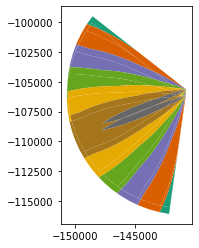

In [19]:
overlapped.plot(color=overlapped["fill"])
plt.show()

In [20]:
overlapped.head()

geometry  title     fill
0  MULTIPOLYGON (((-141554.262 -111823.343, -1415...  -12.0  #1b9e77
1  POLYGON ((-148755.996 -100244.887, -148746.274...  -11.0  #d95f02
2  POLYGON ((-142882.061 -115387.484, -142877.258...  -11.0  #d95f02
3  MULTIPOLYGON (((-140760.955 -106178.665, -1407...  -11.0  #d95f02
4  MULTIPOLYGON (((-140812.708 -106137.706, -1408...  -10.0  #7570b3

In [21]:
final = overlapped.to_crs("epsg:4326")
final.head()

geometry  title     fill
0  MULTIPOLYGON (((8.52490 49.97677, 8.52488 49.9...  -12.0  #1b9e77
1  POLYGON ((8.41990 50.07911, 8.42004 50.07908, ...  -11.0  #d95f02
2  POLYGON ((8.50773 49.94439, 8.50779 49.94448, ...  -11.0  #d95f02
3  MULTIPOLYGON (((8.53386 50.02773, 8.53377 50.0...  -11.0  #d95f02
4  MULTIPOLYGON (((8.53312 50.02808, 8.53310 50.0...  -10.0  #7570b3

In [26]:
d = json.loads(final.to_json())
d

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'fill': '#1b9e77', 'title': -12.0},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[8.524900659596392, 49.97676774649528],
       [8.524884960819067, 49.9766783473914],
       [8.52486926209719, 49.97658894837682],
       [8.524853563434508, 49.97649954936159],
       [8.524837864831019, 49.97641015034574],
       [8.524822166286722, 49.97632075132925],
       [8.52480646780162, 49.976231352312105],
       [8.524790769375707, 49.97614195329434],
       [8.52477507086953, 49.97605255427351],
       [8.524759372562004, 49.97596315525445],
       [8.52474367431367, 49.97587375623477],
       [8.524727976124527, 49.975784357214444],
       [8.524712277994576, 49.97569495819348],
       [8.524696579923814, 49.97560555917189],
       [8.524680881912245, 49.97551616014966],
       [8.524665183959863, 49.975426761126776],
       [8.524649486070421, 49.97533736201333],
       [8.524633

In [66]:
for x in contents.data["features"]:
    x["properties"]['popup'] = x["properties"]["title"]

In [78]:
contents.data["features"][0]

{'id': '0',
 'type': 'Feature',
 'properties': {'fill': '#1b9e77',
  'title': -12.0,
  'popup': -12.0,
  'tooltip': -12.0},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[8.524900659596392, 49.97676774649528],
     [8.524884960819067, 49.9766783473914],
     [8.52486926209719, 49.97658894837682],
     [8.524853563434508, 49.97649954936159],
     [8.524837864831019, 49.97641015034574],
     [8.524822166286722, 49.97632075132925],
     [8.52480646780162, 49.976231352312105],
     [8.524790769375707, 49.97614195329434],
     [8.52477507086953, 49.97605255427351],
     [8.524759372562004, 49.97596315525445],
     [8.52474367431367, 49.97587375623477],
     [8.524727976124527, 49.975784357214444],
     [8.524712277994576, 49.97569495819348],
     [8.524696579923814, 49.97560555917189],
     [8.524680881912245, 49.97551616014966],
     [8.524665183959863, 49.975426761126776],
     [8.524649486070421, 49.97533736201333],
     [8.524633788236418, 49.97524796298919],
     [8.5246180

In [79]:
x0,y0 = 8.534724, 50.032642
m = folium.Map([y0,x0], zoom_start=12, tiles="Stamen Terrain")
contents = folium.GeoJson(
    d,
    style_function=lambda x: {
        'color':  x['properties']['fill'],
        'opacity':   2,
        'weight' : 0
    },
    popup = "hello"
)

# for x in contents.data["features"]:
#     x["properties"]['tooltip'] = x["properties"]["title"]
    
contents.add_to(m)
m

In [81]:
m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")

tooltip = "Click me!"

contents = folium.Marker(
    [45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m)

folium.Marker(
    [45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip
)

contents.add_to(m)

m

In [83]:
contents